In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# ── Paths (edit if your folder name differs) ───────────────────────────────────
ROOT = "/content/drive/MyDrive/celeba_dataset"
SRC_DIR = f"{ROOT}/Celebrity Image Subsets"    # contains images__<ID>_ folders
COMP_ROOT = f"{ROOT}/CompositeDataset"         # will be created

IMAGES_DIR = f"{COMP_ROOT}/images"
LABELS_DIR = f"{COMP_ROOT}/labels"
META_DIR   = f"{COMP_ROOT}/meta"

# ── Create folders ─────────────────────────────────────────────────────────────
import os, shutil, random, json, math, glob
from pathlib import Path

for p in [COMP_ROOT, IMAGES_DIR, LABELS_DIR, META_DIR]:
    os.makedirs(p, exist_ok=True)
for split in ["train","val","test"]:
    os.makedirs(f"{IMAGES_DIR}/{split}", exist_ok=True)
    os.makedirs(f"{LABELS_DIR}/{split}", exist_ok=True)

# ── Install deps ───────────────────────────────────────────────────────────────
!pip -q install ultralytics==8.3.34 opencv-python pillow numpy tqdm

import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from tqdm.auto import tqdm
random.seed(42)
np.random.seed(42)


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# ── Parse celeb IDs from folder names images__<ID>_ ────────────────────────────
folders = sorted([p for p in glob.glob(f"{SRC_DIR}/images__*_") if os.path.isdir(p)])
def parse_id(path):
    # expects .../images__<ID>_/
    base = os.path.basename(path.strip("/"))

    try:
        return base.split("__")[1].rstrip("_")
    except Exception:
        return None

raw_ids = [parse_id(p) for p in folders]
celeb_ids = [cid for cid in raw_ids if cid is not None]
assert len(celeb_ids) >= 2, "No celebrity folders found. Check naming pattern."

# Ensure unique & stable order (sorted as strings keeps IDs like 3401 intact)
celeb_ids = sorted(list(set(celeb_ids)), key=lambda x: int(x))
num_classes = len(celeb_ids)
print(f"Found {num_classes} celebrity IDs.")

# ── Build id_map.csv (idx → celeb_id) ─────────────────────────────────────────
import csv
with open(f"{META_DIR}/id_map.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["idx","celeb_id"])
    for idx, cid in enumerate(celeb_ids):
        writer.writerow([idx, cid])

# Helper: map celeb_id -> class_idx
id_to_idx = {cid: i for i, cid in enumerate(celeb_ids)}


Found 45 celebrity IDs.


In [ ]:

GRID_ROWS, GRID_COLS = 4, 4     # 4×4 grid (16 cells)
CANVAS = (1024, 1024)           # larger image so faces stay visible
CELL_W = CANVAS[0] // GRID_COLS
CELL_H = CANVAS[1] // GRID_ROWS
GUTTER = 8                      # slightly smaller gaps

N_BASE = 1600
SPLIT_COUNTS = {"train": 1120, "val": 240, "test": 240}


# Gather image lists per celeb_id
id_to_images = {}
valid_exts = {".jpg",".jpeg",".png",".bmp"}
for cid in celeb_ids:
    folder = f"{SRC_DIR}/images__{cid}_"
    imgs = []
    for ext in valid_exts:
        imgs.extend(glob.glob(f"{folder}/**/*{ext}", recursive=True))
    imgs = [p for p in imgs if os.path.isfile(p)]
    if len(imgs) == 0:
        print(f"Warning: no images for celeb {cid}")
    id_to_images[cid] = imgs

# Round-robin sampler to keep balance across 45 celebs
from itertools import cycle
rr_ids = []
repeat = math.ceil((N_BASE * GRID_ROWS * GRID_COLS) / len(celeb_ids))  # total slots / num IDs
balanced_list = celeb_ids * repeat
random.shuffle(balanced_list)
rr = cycle(balanced_list)


In [ ]:
def fit_within(img: Image.Image, cell_w, cell_h, keep_aspect=True):
    """Resize PIL image to fit within cell while keeping aspect; returns resized image."""
    if keep_aspect:
        img = img.copy()
        img.thumbnail((cell_w - GUTTER, cell_h - GUTTER), Image.LANCZOS)
        return img
    else:
        return img.resize((cell_w - GUTTER, cell_h - GUTTER), Image.LANCZOS)

def cell_origin(col, row, cell_w, cell_h, gutter=0):
    x0 = col*cell_w + gutter//2
    y0 = row*cell_h + gutter//2
    return x0, y0

def paste_center(canvas: Image.Image, tile: Image.Image, x0, y0, cell_w, cell_h):
    """Paste tile centered within the cell at (x0,y0). Returns (xmin,ymin,xmax,ymax) on canvas."""
    tw, th = tile.size
    cx = x0 + cell_w//2
    cy = y0 + cell_h//2
    xmin = int(cx - tw//2)
    ymin = int(cy - th//2)
    xmin = max(xmin, x0)
    ymin = max(ymin, y0)
    xmax = min(xmin + tw, x0 + cell_w - 1)
    ymax = min(ymin + th, y0 + cell_h - 1)
    canvas.paste(tile, (xmin, ymin))
    return xmin, ymin, xmax, ymax

def xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H):
    w = max(1, xmax - xmin + 1)
    h = max(1, ymax - ymin + 1)
    cx = xmin + w/2
    cy = ymin + h/2
    return cx/W, cy/H, w/W, h/H

def rand_pick_image(cid):
    imgs = id_to_images.get(cid, [])
    if not imgs:
        return None
    return random.choice(imgs)


In [ ]:
def next_n_distinct(rr_iter, pool, n):
    """Return n distinct celeb IDs with available images."""
    chosen = set()
    attempt = 0
    while len(chosen) < n and attempt < 2000:
        c = next(rr_iter)
        if c in pool and id_to_images.get(c):
            chosen.add(c)
        attempt += 1
    return list(chosen)

counter = {"train": 0, "val": 0, "test": 0}
index = 0

for split in ["train", "val", "test"]:
    target = SPLIT_COUNTS[split]
    pbar = tqdm(total=target, desc=f"Building {split} composites")
    built = 0
    while built < target:
        # choose distinct celeb IDs for a 4x4 grid (16 total)
        num_needed = GRID_ROWS * GRID_COLS   # = 16 if 4x4
        cids = next_n_distinct(rr, celeb_ids, num_needed)
        if len(cids) < num_needed:
            print(f"Warning: Only found {len(cids)} distinct celeb IDs for a {GRID_ROWS}x{GRID_COLS} grid. Skipping.")
            continue

        canvas = Image.new("RGB", CANVAS, (245, 245, 245))
        labels = []
        ok = True
        used = set()

        # place tiles row-major
        for r in range(GRID_ROWS):
            for c in range(GRID_COLS):
                cid = cids[r * GRID_COLS + c]
                if cid in used:
                    ok = False
                    break
                used.add(cid)

                src_path = rand_pick_image(cid)
                if src_path is None:
                    ok = False
                    break

                try:
                    tile = Image.open(src_path).convert("RGB")
                except:
                    ok = False
                    break

                tile = fit_within(tile, CELL_W, CELL_H, keep_aspect=True)
                x0, y0 = cell_origin(c, r, CELL_W, CELL_H, GUTTER)
                xmin, ymin, xmax, ymax = paste_center(canvas, tile, x0, y0, CELL_W, CELL_H)
                cx, cy, w, h = xyxy_to_yolo(xmin, ymin, xmax, ymax, CANVAS[0], CANVAS[1])

                class_idx = id_to_idx[cid]
                labels.append((class_idx, cx, cy, w, h))
            if not ok:
                break

        # skip if image incomplete
        if not ok or len(labels) != num_needed:
            continue

        stem = f"comp_{index:06d}"
        img_out = f"{IMAGES_DIR}/{split}/{stem}.jpg"
        lab_out = f"{LABELS_DIR}/{split}/{stem}.txt"

        canvas.save(img_out, quality=92)
        with open(lab_out, "w") as f:
            for cls, cx, cy, w, h in labels:
                f.write(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        built += 1
        index += 1
        pbar.update(1)
    pbar.close()


Building train composites:   0%|          | 0/1120 [00:00<?, ?it/s]

Building val composites:   0%|          | 0/240 [00:00<?, ?it/s]

Building test composites:   0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
AUG_TRAIN = True

def augment_photometric(pil_img):
    # mild brightness & contrast jitter, occasional blur
    br = ImageEnhance.Brightness(pil_img).enhance( np.random.uniform(0.9, 1.1) )
    ct = ImageEnhance.Contrast(br).enhance( np.random.uniform(0.9, 1.1) )
    if np.random.rand() < 0.25:
        ct = ct.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0.2, 0.8)))
    return ct

def flip_labels_horiz(yolo_lines):
    out = []
    for line in yolo_lines:
        cls, cx, cy, w, h = line
        cx_flipped = 1.0 - cx
        out.append((cls, cx_flipped, cy, w, h))
    return out

if AUG_TRAIN:
    train_imgs = sorted(glob.glob(f"{IMAGES_DIR}/train/*.jpg"))
    for img_path in tqdm(train_imgs, desc="Augmenting train (+1x)"):
        stem = Path(img_path).stem
        lab_path = f"{LABELS_DIR}/train/{stem}.txt"
        if not os.path.exists(lab_path):
            continue

        # read labels
        yolo_lines = []
        with open(lab_path, "r") as f:
            for ln in f:
                toks = ln.strip().split()
                cls = int(toks[0]); cx,cy,w,h = map(float, toks[1:5])
                yolo_lines.append((cls,cx,cy,w,h))

        # 50% flip horizontally
        img = Image.open(img_path).convert("RGB")
        do_flip = np.random.rand() < 0.5
        if do_flip:
            img_aug = img.transpose(Image.FLIP_LEFT_RIGHT)
            labels_aug = flip_labels_horiz(yolo_lines)
        else:
            img_aug = img.copy()
            labels_aug = yolo_lines

        # photometric
        img_aug = augment_photometric(img_aug)

        # save with new stem
        new_stem = stem + "_aug1"
        img_out = f"{IMAGES_DIR}/train/{new_stem}.jpg"
        lab_out = f"{LABELS_DIR}/train/{new_stem}.txt"

        img_aug.save(img_out, quality=92)
        with open(lab_out, "w") as f:
            for (cls,cx,cy,w,h) in labels_aug:
                f.write(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")


Augmenting train (+1x):   0%|          | 0/1120 [00:00<?, ?it/s]

In [ ]:
data_yaml = {
    "path": COMP_ROOT,
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "nc":    num_classes,
    "names": [str(cid) for cid in celeb_ids]  # <- true celeb IDs as strings
}
import yaml
with open(f"{COMP_ROOT}/data.yaml", "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

# Record build meta for reproducibility
build_log = {
    "grid": {"rows": GRID_ROWS, "cols": GRID_COLS, "canvas": CANVAS, "gutter": GUTTER},
    "counts": {"base_total": N_BASE, **SPLIT_COUNTS},
    "aug": {"train_plus_one": bool(AUG_TRAIN), "ops": ["flip(0.5)", "brightness/contrast", "blur(0.25)"]},
    "classes": num_classes,
    "note": "Label class_idx follows meta/id_map.csv; names[] are true celeb IDs."
}
with open(f"{META_DIR}/build_log.json","w") as f:
    json.dump(build_log, f, indent=2)


In [ ]:
from ultralytics import YOLO

data_path = f"{COMP_ROOT}/data.yaml"  # same as before
model = YOLO("yolov8n.pt")

model.train(
    data=data_path,
    imgsz=1024,
    epochs=100,
    batch=16,
    device=0,
    mosaic=1.0,         # spatial: combines random images
    mixup=0.5,          # spatial + visual: blends images
    copy_paste=0.5,     # spatial: pastes objects randomly (overlaps)
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,  # visual color jitter
    degrees=5.0,        # small rotation (optional)
    translate=0.1,      # move objects around (optional)
    scale=0.5,          # random zoom in/out (optional)
    shear=2.0,          # slight skew (optional)
    project=f"{COMP_ROOT}/runs",
    name="yolov8n_grid4x4_spatial_aug"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 405MB/s]

New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'


Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/celeba_dataset/CompositeDataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/celeba_dataset/CompositeDataset/runs, name=yolov8n_grid4x4_spatial_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

100%|██████████| 755k/755k [00:00<00:00, 135MB/s]


Overriding model.yaml nc=80 with nc=45

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 421MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/celeba_dataset/CompositeDataset/labels/train... 2240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2240/2240 [00:23<00:00, 96.68it/s] 


train: New cache created: /content/drive/MyDrive/celeba_dataset/CompositeDataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/celeba_dataset/CompositeDataset/labels/val... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:01<00:00, 125.34it/s]


val: New cache created: /content/drive/MyDrive/celeba_dataset/CompositeDataset/labels/val.cache
Plotting labels to /content/drive/MyDrive/celeba_dataset/CompositeDataset/runs/yolov8n_grid4x4_spatial_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000204, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/celeba_dataset/CompositeDataset/runs/yolov8n_grid4x4_spatial_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.26G     0.6876      4.128      1.119        522       1024: 100%|██████████| 140/140 [00:29<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


                   all        240       3840     0.0235      0.427     0.0262     0.0262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.87G     0.3712      3.492     0.9344        515       1024: 100%|██████████| 140/140 [00:27<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]


                   all        240       3840      0.192      0.257      0.116      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.77G     0.3475      2.928     0.9349        524       1024: 100%|██████████| 140/140 [00:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


                   all        240       3840      0.258      0.437      0.333      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.73G     0.3168      2.435     0.9199        552       1024: 100%|██████████| 140/140 [00:28<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


                   all        240       3840      0.511      0.622      0.607      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.73G     0.2965       2.03      0.905        645       1024: 100%|██████████| 140/140 [00:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


                   all        240       3840      0.754      0.737      0.803      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.37G      0.284      1.701      0.897        549       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


                   all        240       3840      0.819      0.845      0.885      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.64G     0.2785       1.49     0.8959        553       1024: 100%|██████████| 140/140 [00:28<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


                   all        240       3840      0.906      0.889      0.943      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       7.5G      0.266      1.303     0.8842        582       1024: 100%|██████████| 140/140 [00:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


                   all        240       3840      0.935       0.93      0.971       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.41G     0.2616      1.178      0.883        503       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        240       3840      0.966      0.951      0.985      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       7.3G     0.2518       1.07     0.8741        688       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


                   all        240       3840      0.965      0.967      0.989      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.16G      0.249      1.001     0.8708        651       1024: 100%|██████████| 140/140 [00:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]


                   all        240       3840      0.964      0.964       0.99       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.81G     0.2393     0.9281     0.8642        558       1024: 100%|██████████| 140/140 [00:28<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        240       3840       0.99      0.985      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.96G     0.2347     0.8776     0.8622        568       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


                   all        240       3840      0.988      0.983      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.31G     0.2364     0.8667     0.8642        587       1024: 100%|██████████| 140/140 [00:28<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


                   all        240       3840      0.991      0.996      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.13G     0.2265      0.803     0.8584        627       1024: 100%|██████████| 140/140 [00:28<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        240       3840      0.995      0.997      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.86G     0.2284     0.7886     0.8586        713       1024: 100%|██████████| 140/140 [00:27<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        240       3840      0.995      0.998      0.995      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.86G     0.2267     0.7731     0.8584        509       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


                   all        240       3840      0.994      0.996      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.15G     0.2227     0.7447     0.8523        587       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.54G     0.2198      0.712     0.8534        594       1024: 100%|██████████| 140/140 [00:28<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


                   all        240       3840      0.995      0.997      0.995      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.22G      0.219     0.7077     0.8521        635       1024: 100%|██████████| 140/140 [00:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


                   all        240       3840      0.996      0.999      0.995      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.75G     0.2149     0.6856     0.8501        558       1024: 100%|██████████| 140/140 [00:27<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


                   all        240       3840      0.997      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.25G     0.2115     0.6568      0.848        561       1024: 100%|██████████| 140/140 [00:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


                   all        240       3840      0.997      0.997      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.12G     0.2095     0.6518     0.8476        578       1024: 100%|██████████| 140/140 [00:27<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


                   all        240       3840      0.997      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.99G     0.2068     0.6446     0.8459        629       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.04G     0.2012     0.6144     0.8423        537       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.08G     0.2063     0.6272     0.8458        677       1024: 100%|██████████| 140/140 [00:28<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.86G     0.2025     0.6061     0.8453        568       1024: 100%|██████████| 140/140 [00:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


                   all        240       3840      0.997      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.23G     0.2046      0.603     0.8451        642       1024: 100%|██████████| 140/140 [00:28<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

                   all        240       3840      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.49G     0.1995     0.5844     0.8411        526       1024: 100%|██████████| 140/140 [00:28<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


                   all        240       3840      0.999      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.58G     0.1972     0.5747     0.8417        677       1024: 100%|██████████| 140/140 [00:27<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]


                   all        240       3840      0.998          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.11G     0.1975     0.5725     0.8417        754       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.65G     0.1998     0.5724     0.8428        584       1024: 100%|██████████| 140/140 [00:27<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.1G     0.1955     0.5587     0.8403        595       1024: 100%|██████████| 140/140 [00:28<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


                   all        240       3840      0.997          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.97G     0.1977     0.5624     0.8412        687       1024: 100%|██████████| 140/140 [00:27<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.92G     0.1905     0.5417     0.8387        599       1024: 100%|██████████| 140/140 [00:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.58G     0.1936     0.5465     0.8375        620       1024: 100%|██████████| 140/140 [00:28<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.11G     0.1894     0.5398     0.8382        635       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.43G     0.1913     0.5327     0.8381        643       1024: 100%|██████████| 140/140 [00:28<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.75G     0.1867     0.5137     0.8359        502       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


                   all        240       3840      0.998      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.86G     0.1841     0.5106     0.8365        615       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

                   all        240       3840      0.998      0.999      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.67G     0.1857     0.5101     0.8358        667       1024: 100%|██████████| 140/140 [00:28<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


                   all        240       3840      0.999      0.998      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.65G     0.1876     0.5151     0.8362        709       1024: 100%|██████████| 140/140 [00:28<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.1G     0.1849     0.5049     0.8351        655       1024: 100%|██████████| 140/140 [00:28<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.32G     0.1813     0.4925     0.8342        540       1024: 100%|██████████| 140/140 [00:27<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.39G     0.1806      0.491     0.8329        462       1024: 100%|██████████| 140/140 [00:27<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.53G     0.1799     0.4846     0.8329        658       1024: 100%|██████████| 140/140 [00:27<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.34G     0.1776     0.4721     0.8309        511       1024: 100%|██████████| 140/140 [00:27<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.19G     0.1794     0.4831     0.8328        679       1024: 100%|██████████| 140/140 [00:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.83G     0.1781     0.4736      0.832        591       1024: 100%|██████████| 140/140 [00:28<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

                   all        240       3840      0.999      0.998      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.59G     0.1756     0.4655     0.8309        671       1024: 100%|██████████| 140/140 [00:27<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.7G     0.1798     0.4787     0.8317        687       1024: 100%|██████████| 140/140 [00:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.92G     0.1778     0.4706      0.832        663       1024: 100%|██████████| 140/140 [00:28<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.69G     0.1748     0.4696     0.8307        587       1024: 100%|██████████| 140/140 [00:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.86G     0.1762     0.4551     0.8295        628       1024: 100%|██████████| 140/140 [00:27<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.42G     0.1735     0.4545     0.8299        597       1024: 100%|██████████| 140/140 [00:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]


                   all        240       3840      0.999      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.74G     0.1769     0.4571     0.8312        653       1024: 100%|██████████| 140/140 [00:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.13G     0.1744     0.4512     0.8301        590       1024: 100%|██████████| 140/140 [00:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       8.4G     0.1739     0.4482     0.8306        523       1024: 100%|██████████| 140/140 [00:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.39G     0.1732     0.4477     0.8308        668       1024: 100%|██████████| 140/140 [00:27<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.81G     0.1699     0.4372     0.8293        676       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.04G     0.1719     0.4526     0.8295        635       1024: 100%|██████████| 140/140 [00:28<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       6.7G     0.1701     0.4354     0.8282        688       1024: 100%|██████████| 140/140 [00:28<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]

                   all        240       3840      0.999      0.999      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.23G     0.1716     0.4358     0.8305        415       1024: 100%|██████████| 140/140 [00:27<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.33G     0.1678     0.4268     0.8287        567       1024: 100%|██████████| 140/140 [00:28<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.17G     0.1704      0.425     0.8286        615       1024: 100%|██████████| 140/140 [00:28<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.08G     0.1685     0.4198     0.8272        619       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.06G     0.1687     0.4277     0.8277        629       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.19G     0.1661     0.4252     0.8271        508       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.32G     0.1659     0.4174     0.8269        514       1024: 100%|██████████| 140/140 [00:28<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.28G     0.1667       0.42     0.8269        538       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.89G     0.1659     0.4178     0.8266        548       1024: 100%|██████████| 140/140 [00:28<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.92G      0.165     0.4133     0.8273        555       1024: 100%|██████████| 140/140 [00:28<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.06it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       7.2G     0.1615     0.4056     0.8246        571       1024: 100%|██████████| 140/140 [00:27<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.12it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.34G     0.1655      0.416     0.8289        540       1024: 100%|██████████| 140/140 [00:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.02G     0.1635      0.416     0.8269        515       1024: 100%|██████████| 140/140 [00:28<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.02it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.89G     0.1619     0.4003     0.8262        457       1024: 100%|██████████| 140/140 [00:27<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.85G     0.1609     0.3931     0.8244        613       1024: 100%|██████████| 140/140 [00:27<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.91G     0.1617     0.4036     0.8264        490       1024: 100%|██████████| 140/140 [00:27<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.56G     0.1615     0.3977      0.825        485       1024: 100%|██████████| 140/140 [00:28<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.09G     0.1601     0.3976     0.8253        549       1024: 100%|██████████| 140/140 [00:28<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.82G     0.1605     0.3955     0.8243        676       1024: 100%|██████████| 140/140 [00:28<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.03G      0.162     0.4007     0.8261        508       1024: 100%|██████████| 140/140 [00:28<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.34G     0.1583     0.3928     0.8243        517       1024: 100%|██████████| 140/140 [00:28<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.47G     0.1566     0.3837     0.8241        552       1024: 100%|██████████| 140/140 [00:28<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.15G     0.1593     0.3909     0.8251        479       1024: 100%|██████████| 140/140 [00:28<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


                   all        240       3840      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.16G     0.1573     0.3881     0.8244        539       1024: 100%|██████████| 140/140 [00:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.51G     0.1566     0.3825     0.8246        643       1024: 100%|██████████| 140/140 [00:28<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.64G     0.1582     0.3811     0.8241        615       1024: 100%|██████████| 140/140 [00:28<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.48G     0.1595     0.3911     0.8239        690       1024: 100%|██████████| 140/140 [00:28<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.18G     0.1569     0.3873     0.8246        668       1024: 100%|██████████| 140/140 [00:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]

                   all        240       3840      0.999          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       5.9G     0.1141     0.2488     0.8049        253       1024: 100%|██████████| 140/140 [00:20<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.20it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       5.9G     0.1033     0.2053     0.8004        251       1024: 100%|██████████| 140/140 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       5.9G    0.09889     0.1942     0.7975        248       1024: 100%|██████████| 140/140 [00:18<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       5.9G    0.09657     0.1882     0.7965        248       1024: 100%|██████████| 140/140 [00:18<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.9G    0.09638     0.1874     0.7963        242       1024: 100%|██████████| 140/140 [00:18<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       5.9G    0.09457      0.184     0.7957        248       1024: 100%|██████████| 140/140 [00:18<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       5.9G      0.094     0.1813     0.7982        253       1024: 100%|██████████| 140/140 [00:18<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       5.9G    0.09198      0.179     0.7958        247       1024: 100%|██████████| 140/140 [00:18<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.9G    0.09308     0.1821     0.7988        245       1024: 100%|██████████| 140/140 [00:18<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

                   all        240       3840      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       5.9G    0.09253     0.1794     0.7972        246       1024: 100%|██████████| 140/140 [00:18<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        240       3840      0.999          1      0.995      0.995



100 epochs completed in 0.827 hours.
Optimizer stripped from /content/drive/MyDrive/celeba_dataset/CompositeDataset/runs/yolov8n_grid4x4_spatial_aug/weights/last.pt, 6.4MB
Optimizer stripped from /content/drive/MyDrive/celeba_dataset/CompositeDataset/runs/yolov8n_grid4x4_spatial_aug/weights/best.pt, 6.4MB

Validating /content/drive/MyDrive/celeba_dataset/CompositeDataset/runs/yolov8n_grid4x4_spatial_aug/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,014,423 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


                   all        240       3840      0.999          1      0.995      0.995
                   228         75         75      0.999          1      0.995      0.995
                   447         78         78      0.999          1      0.995      0.995
                   487         81         81      0.999          1      0.995      0.995
                   800         75         75      0.999          1      0.995      0.995
                  1158         85         85      0.999          1      0.995      0.995
                  1499         83         83      0.999          1      0.995      0.995
                  1852         90         90      0.999          1      0.995      0.995
                  1964         79         79      0.999          1      0.995      0.995
                  2425         84         84      0.999          1      0.995      0.995
                  2463         79         79      0.999          1      0.995      0.995
                  252

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e06e441a6c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,

In [ ]:
from ultralytics import YOLO
import pandas as pd

# Load best weights
runs_dir = f"{COMP_ROOT}/runs/yolov8n_grid4x4_spatial_aug/weights"
best = f"{runs_dir}/best.pt"

predictor = YOLO(best)
test_images = sorted(glob.glob(f"{IMAGES_DIR}/test/*.jpg"))[:12]  # a few samples

results = predictor.predict(
    source=test_images,
    imgsz=640,
    conf=0.25,
    save=True,                      # saves images with boxes
   project=f"{COMP_ROOT}/preds",
name="test_samples_4x4",
    verbose=False
)

# Pretty print: Celeb ID, conf, bbox (xyxy)
for r, img_path in zip(results, test_images):
    print(f"\nImage: {Path(img_path).name}")
    if r.boxes is None or len(r.boxes) == 0:
        print("  No detections.")
        continue
    ids = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()
    xyxy = r.boxes.xyxy.cpu().numpy()

    rows = []
    for i, c in enumerate(ids):
        celeb_id_str = data_yaml["names"][c]   # true celeb ID string
        x1,y1,x2,y2 = xyxy[i]
        rows.append([celeb_id_str, float(confs[i]), (int(x1),int(y1),int(x2),int(y2))])
    df = pd.DataFrame(rows, columns=["Celeb ID","Confidence","Bbox (x_min,y_min,x_max,y_max)"])
    display(df)

Results saved to /content/drive/MyDrive/celeba_dataset/CompositeDataset/preds/test_samples_4x4

Image: comp_001360.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,8722,0.992394,"(42, 789, 221, 1010)"
1,3782,0.989751,"(42, 278, 220, 497)"
2,2880,0.989640,"(298, 21, 477, 241)"
3,2837,0.988910,"(298, 278, 477, 498)"
4,3321,0.988664,"(554, 790, 733, 1010)"
5,3401,0.988539,"(554, 22, 733, 242)"
6,9319,0.987292,"(43, 22, 221, 241)"
7,1964,0.986239,"(810, 533, 989, 753)"
8,800,0.985735,"(553, 278, 734, 497)"
9,8265,0.985430,"(298, 533, 477, 754)"



Image: comp_001361.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,10046,0.997457,"(553, 533, 733, 754)"
1,8045,0.994775,"(553, 277, 733, 498)"
2,228,0.990196,"(554, 22, 733, 243)"
3,3698,0.990065,"(811, 789, 989, 1011)"
4,1964,0.989834,"(297, 533, 477, 753)"
5,4561,0.988669,"(42, 533, 221, 753)"
6,800,0.988202,"(298, 22, 478, 241)"
7,6568,0.987839,"(297, 278, 477, 498)"
8,4126,0.986053,"(810, 22, 989, 242)"
9,487,0.984750,"(42, 278, 221, 498)"



Image: comp_001362.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,1964,0.993127,"(810, 534, 989, 753)"
1,6098,0.990465,"(42, 791, 222, 1010)"
2,2837,0.989968,"(810, 789, 990, 1010)"
3,3401,0.988413,"(554, 22, 733, 242)"
4,8945,0.988309,"(298, 790, 477, 1010)"
5,8656,0.987059,"(298, 533, 477, 755)"
6,3321,0.986128,"(556, 789, 734, 1010)"
7,4126,0.985042,"(810, 278, 990, 498)"
8,447,0.983541,"(554, 278, 733, 498)"
9,228,0.982863,"(298, 277, 477, 498)"



Image: comp_001363.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,1964,0.993239,"(554, 534, 733, 754)"
1,3698,0.993224,"(811, 790, 989, 1011)"
2,2522,0.992526,"(298, 790, 477, 1010)"
3,2837,0.990382,"(554, 22, 733, 242)"
4,7904,0.989419,"(42, 789, 221, 1010)"
5,2880,0.988704,"(42, 21, 221, 242)"
6,2425,0.987115,"(810, 21, 989, 242)"
7,228,0.986963,"(42, 278, 221, 498)"
8,7282,0.986731,"(298, 534, 478, 754)"
9,8265,0.985629,"(43, 534, 221, 754)"



Image: comp_001364.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,9319,0.994704,"(42, 22, 221, 242)"
1,1964,0.994323,"(810, 278, 989, 497)"
2,2522,0.991735,"(554, 22, 733, 242)"
3,8722,0.991394,"(41, 789, 221, 1011)"
4,3698,0.990312,"(810, 790, 989, 1010)"
5,6568,0.988879,"(298, 278, 477, 498)"
6,3699,0.988588,"(554, 790, 734, 1012)"
7,9151,0.988541,"(810, 533, 990, 754)"
8,800,0.987615,"(298, 22, 478, 241)"
9,7904,0.987494,"(554, 534, 733, 754)"



Image: comp_001365.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,10046,0.991298,"(554, 534, 732, 753)"
1,8968,0.991209,"(297, 789, 477, 1010)"
2,3782,0.989496,"(298, 23, 477, 242)"
3,2837,0.989251,"(42, 23, 221, 242)"
4,3698,0.989104,"(810, 789, 989, 1011)"
5,2522,0.988871,"(42, 277, 221, 499)"
6,4561,0.984634,"(298, 534, 477, 753)"
7,3321,0.984531,"(810, 534, 989, 755)"
8,8656,0.984400,"(42, 533, 221, 754)"
9,3699,0.984320,"(554, 789, 733, 1009)"



Image: comp_001366.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,9063,0.991981,"(554, 278, 733, 498)"
1,1964,0.991367,"(553, 533, 734, 754)"
2,3698,0.989308,"(810, 790, 989, 1011)"
3,3745,0.988338,"(298, 534, 477, 754)"
4,4304,0.986392,"(810, 20, 988, 242)"
5,3699,0.985600,"(42, 789, 222, 1011)"
6,1499,0.985464,"(42, 278, 221, 499)"
7,800,0.984659,"(42, 21, 221, 241)"
8,3782,0.984187,"(298, 22, 477, 242)"
9,10173,0.984011,"(553, 790, 733, 1010)"



Image: comp_001367.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,3699,0.990934,"(297, 790, 477, 1010)"
1,1158,0.990614,"(810, 277, 990, 498)"
2,6568,0.990235,"(298, 534, 476, 754)"
3,1852,0.989687,"(298, 22, 477, 243)"
4,9063,0.989290,"(554, 277, 733, 498)"
5,8656,0.985353,"(810, 534, 990, 754)"
6,8045,0.985050,"(555, 533, 734, 754)"
7,447,0.985037,"(42, 277, 221, 497)"
8,2463,0.984864,"(42, 20, 222, 242)"
9,10173,0.984285,"(554, 790, 733, 1010)"



Image: comp_001368.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,9151,0.994335,"(43, 790, 221, 1011)"
1,9256,0.991547,"(42, 534, 221, 754)"
2,2837,0.990097,"(298, 790, 477, 1010)"
3,10173,0.988546,"(554, 790, 733, 1010)"
4,3227,0.987405,"(298, 22, 477, 242)"
5,9152,0.987396,"(554, 21, 732, 242)"
6,4126,0.986676,"(554, 278, 733, 498)"
7,8656,0.986469,"(810, 278, 990, 498)"
8,2425,0.986374,"(42, 278, 220, 498)"
9,8968,0.984420,"(810, 790, 989, 1010)"



Image: comp_001369.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,3699,0.993568,"(298, 790, 477, 1010)"
1,2463,0.992599,"(42, 21, 222, 243)"
2,8656,0.992125,"(554, 534, 733, 754)"
3,1158,0.991674,"(809, 277, 990, 497)"
4,9256,0.991415,"(810, 534, 989, 754)"
5,3321,0.990817,"(554, 790, 733, 1010)"
6,1964,0.989738,"(43, 790, 221, 1009)"
7,9063,0.987768,"(41, 533, 221, 754)"
8,3782,0.987416,"(553, 22, 734, 241)"
9,4126,0.987054,"(298, 277, 477, 498)"



Image: comp_001370.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,9256,0.992937,"(554, 534, 733, 754)"
1,3698,0.992308,"(810, 790, 990, 1009)"
2,3782,0.991191,"(810, 22, 990, 242)"
3,2463,0.991067,"(42, 21, 221, 242)"
4,3745,0.990016,"(298, 534, 477, 754)"
5,9151,0.988726,"(298, 790, 478, 1011)"
6,4561,0.987414,"(42, 789, 221, 1010)"
7,3401,0.987082,"(298, 22, 477, 242)"
8,4126,0.986777,"(810, 277, 990, 497)"
9,8265,0.986738,"(42, 534, 221, 754)"



Image: comp_001371.jpg


,Celeb ID,Confidence,"Bbox (x_min,y_min,x_max,y_max)"
0,8871,0.992881,"(809, 278, 989, 498)"
1,3698,0.989215,"(811, 790, 989, 1011)"
2,3321,0.989191,"(42, 789, 221, 1011)"
3,9256,0.989054,"(298, 533, 477, 754)"
4,8968,0.988504,"(554, 790, 733, 1010)"
5,7904,0.988471,"(553, 21, 733, 242)"
6,5239,0.987817,"(298, 278, 477, 499)"
7,8656,0.987162,"(41, 534, 221, 754)"
8,1852,0.986947,"(42, 22, 221, 242)"
9,3431,0.985788,"(298, 22, 477, 242)"


Saving img3 5.jpg to img3 5 (1).jpg

image 1/1 /content/img3 5 (1).jpg: 1024x1024 2 228s, 1 2522, 1 2562, 1 3431, 2 3698s, 1 3699, 1 4304, 1 7282, 1 9319, 7.9ms
Speed: 5.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


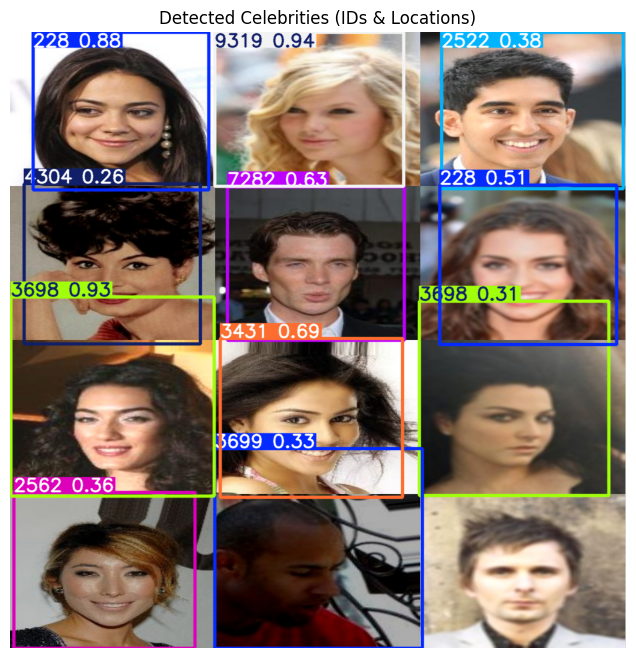


Predictions:
  ID: 9319 | Conf: 0.94 | Box: (340, 0, 654, 256)
  ID: 3698 | Conf: 0.93 | Box: (1, 440, 339, 771)
  ID: 228 | Conf: 0.88 | Box: (38, 0, 330, 262)
  ID: 3431 | Conf: 0.69 | Box: (349, 509, 652, 773)
  ID: 7282 | Conf: 0.63 | Box: (361, 257, 655, 512)
  ID: 228 | Conf: 0.51 | Box: (714, 254, 1008, 519)
  ID: 2522 | Conf: 0.38 | Box: (717, 0, 1019, 260)
  ID: 2562 | Conf: 0.36 | Box: (6, 765, 307, 1024)
  ID: 3699 | Conf: 0.33 | Box: (340, 692, 685, 1024)
  ID: 3698 | Conf: 0.31 | Box: (680, 447, 995, 770)
  ID: 4304 | Conf: 0.26 | Box: (23, 252, 316, 518)


In [ ]:
# --- Simple Object Detection Demo ---
from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt
from google.colab import files

# Load model and label info
COMP_ROOT = "/content/drive/MyDrive/celeba_dataset/CompositeDataset"
MODEL_PATH = f"{COMP_ROOT}/runs/yolov8n_grid4x4_spatial_aug/weights/best.pt"
DATA_YAML = f"{COMP_ROOT}/data.yaml"

model = YOLO(MODEL_PATH)
with open(DATA_YAML, "r") as f:
    names = yaml.safe_load(f)["names"]

# Upload input image (professor gives in class)
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Run detection
res = model(img_path, conf=0.25, imgsz=1024)[0]

# Display result with bounding boxes
annotated = res.plot()
plt.figure(figsize=(8,8))
plt.imshow(annotated[..., ::-1])
plt.axis("off")
plt.title("Detected Celebrities (IDs & Locations)")
plt.show()

# Print detections (ID, confidence, box)
print("\nPredictions:")
for i, cid in enumerate(res.boxes.cls.cpu().numpy().astype(int)):
    conf = float(res.boxes.conf[i])
    x1, y1, x2, y2 = res.boxes.xyxy[i].cpu().numpy()
    print(f"  ID: {names[cid]} | Conf: {conf:.2f} | Box: ({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)})")


In [ ]:
!pip -q install ultralytics==8.3.34 opencv-python pillow numpy tqdm

In [5]:
!git add .

error: 'deep_final/' does not have a commit checked out
fatal: adding files failed
